In [1]:
from scholarly import scholarly
import csv
import warnings
import ast
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as CM
from tqdm import tqdm

In [2]:
# !!! Modify this to match the name of your author list CSV file. 
author_list_csv = 'authorlist.csv'
output_data_csv = 'Example Outputs/ss_output_data.csv'

In [3]:
authorlist_df = pd.read_csv(author_list_csv)

# author_names= []
# with open(author_list_csv, encoding ="utf-8-sig") as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter =',')
#     for row in csv_reader:
#         if (len(row) == 1):
#             author_names.append(row[0])

In [4]:
affiliations = [
    'University of British Columbia', 
    'UBC', 
    'Djavad Mowafaghian', 
    'Simon Fraser University', 
    'University of Victoria', 
    'University of Washington'
    ]

In [5]:
# This will contain all the data for each author which will be exported as a table. It will be a list of dictionaries. 
rows = []
# This will contain a list of dictionaries for each author. The dictionaries will be made up of years as keys and citation numbers as vals
cites_per_year = []
# This dictionary will contain publication titles as keys and author names as values
pub_authors = {}


for idx, athr in tqdm(authorlist_df.iterrows(), total=authorlist_df.shape[0]):
    pubs = []
    used_athr_ID = False
    try :
        if pd.isna(athr["GSID"]):
            search_query = scholarly.search_author(athr['Name'])
            author = next(search_query) 
        else:
            author = scholarly.search_author_id(athr['GSID'])
            used_athr_ID = True
    except (RuntimeError,TypeError,StopIteration):
        row = {'Name': athr, 'Warning': 'no information found'}
    else:
        data_dict = scholarly.fill(author, sections=['basics', 'indices', 'publications', 'counts'])
        
        # Get publications titles 
        for pub in data_dict['publications']:
            pubs.append(pub['bib']['title'].replace("|", " "))
            # Add to dictionary with title as key and author as value
            # Do not add duplicates of authors
            if (pub['bib']['title'] not in pub_authors.keys()) or (athr['Name'] not in pub_authors[pub['bib']['title']]): 
                pub_authors.setdefault(pub['bib']['title'],[]).append(athr['Name'])
        
        # Get citations per year and put in dictionary
        cites_per_year_dict = data_dict['cites_per_year']
        # Add name to dictionary 
        cites_per_year_dict['name'] = data_dict['name']
        cites_per_year.append(cites_per_year_dict)
        
        # Create row (dictionary) for output data table
        row = {'Name': athr['Name'],
               'Name on Profile': data_dict['name'],
               'Scholar ID': data_dict['scholar_id'], 
               'Cited by': data_dict.get('citedby', ''), 
               'Cited by 5 years': data_dict.get('citedby5y',''), 
               'h-index': data_dict.get('hindex',''), 
               'h-index 5 years': data_dict.get('hindex5y',''), 
               'i10-index': data_dict.get('i10index',''),
               'i10-index 5 years': data_dict.get('i10index5y',''), 
               'Publications': pubs, 
               'Document Count': len(pubs), 
               'Affiliation': data_dict['affiliation']
               }
        
        # Create list of authors who do not have the specified affiliation
        if used_athr_ID == False and not any(a in data_dict['affiliation'] for a in affiliations):
            row['Warning'] = "Affiliation does not match!"
            
    finally:    
        rows.append(row)

100%|██████████| 82/82 [05:58<00:00,  4.37s/it]


In [6]:
# # use desired names in coauthor list rather than names on profile
# expected_names = [row['Name'] for row in rows]
# profile_names = [row['GS Profile Name'] for row in rows]
# names_dict = {profile_names[i]:expected_names[i] for i in range(len(expected_names))}

# for title, coauthors in pub_authors:
#     pub_authors[title] = [names_dict[name] for name in coauthors]

In [7]:
# Create dictionary with author names as keys and dictionary (coauthor name as key, number of collaborations as value) 
#   as value
collabs_dict={}
for key in pub_authors:
    for author in pub_authors[key]:
        for coauthor in pub_authors[key]:
            if coauthor is not author:
                if author not in collabs_dict.keys() or coauthor not in collabs_dict[author].keys():
                    collabs_dict.setdefault(author,{})[coauthor]=1
                else:
                    collabs_dict[author][coauthor]+=1


# Write to rows dataframe
for row in rows:
    if row['Name'] in collabs_dict.keys():
        row['Coauthors'] = collabs_dict[row['Name']]

In [8]:
# Uncomment to create CSV table for viewing publications with shared coauthors

coauthored_pubs = [
    title
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_authors = [
    authors
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_df = pd.DataFrame({"Title": coauthored_pubs, "Authors": coauthored_authors})

print(coauthored_df.head())

coauthored_df.to_csv("Example Outputs/shared_pubs.csv",index=False,sep="|")

                                               Title  \
0  A Performance analysis of objective video qual...   
1  Data-parallel full reference algorithm for dro...   
2  Automatic detection of DBSCAN parameters using...   
3  Secret Data Hiding using Artificial Neural Net...   
4  A hybrid video quality metric for analyzing qu...   

                                             Authors  
0            [Prof. Manish Kumar Thakur, Dr. Vikash]  
1            [Prof. Manish Kumar Thakur, Dr. Vikash]  
2       [Prof. Manish Kumar Thakur, Dr. Sherry Garg]  
3  [Prof. Manish Kumar Thakur, Dr. Tribhuwan Kuma...  
4            [Prof. Manish Kumar Thakur, Dr. Vikash]  


In [9]:
# Specify the order of the data. These keys must match the names of the keys in the rows dictionary. 
keys = ['Name',
        'Name on Profile', 
        'Scholar ID', 
        'Document Count', 
        'Cited by', 
        'Cited by 5 years', 
        'h-index', 
        'h-index 5 years', 
        'i10-index', 
        'i10-index 5 years', 
        'Publications', 
        'Coauthors', 
        'Affiliation', 
        'Warning']

# This creates/opens the file with filename with the intention to write to the csv_file
# The encoding allows the characters to be properly written to the csv_file
with open(output_data_csv, mode='w', encoding ="utf-8", newline="") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter='|', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer = csv.DictWriter(csv_file, keys, delimiter='|', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer.writeheader()
    dict_writer.writerows(rows)

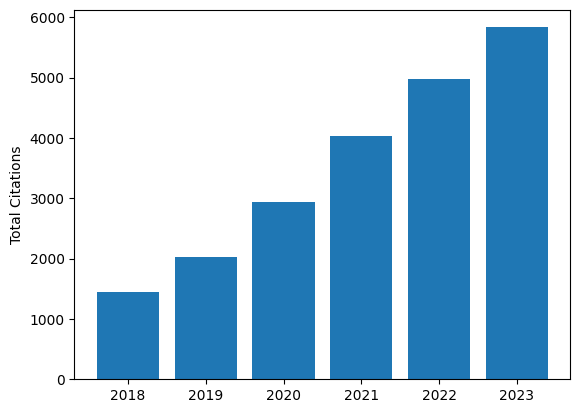

In [10]:
# Create citations per year dataframe
cites_df = pd.DataFrame(cites_per_year)

# Add a totals column
cites_df.loc['Total']= cites_df.sum()

# !!! Select years to plot
cites_df_selected = cites_df[[2018,2019,2020,2021,2022,2023]]

# Select the last row (totals) 
cites_df_total = cites_df_selected.iloc[-1:]

# Create barplot
years = list(cites_df_total.columns)
cites = cites_df_total.values.tolist()[0]
plt.bar(years, cites )
plt.ylabel('Total Citations')

# !!! Modify this - name the output PDF file
plt.savefig("Example Outputs/Graphs/citations.pdf")

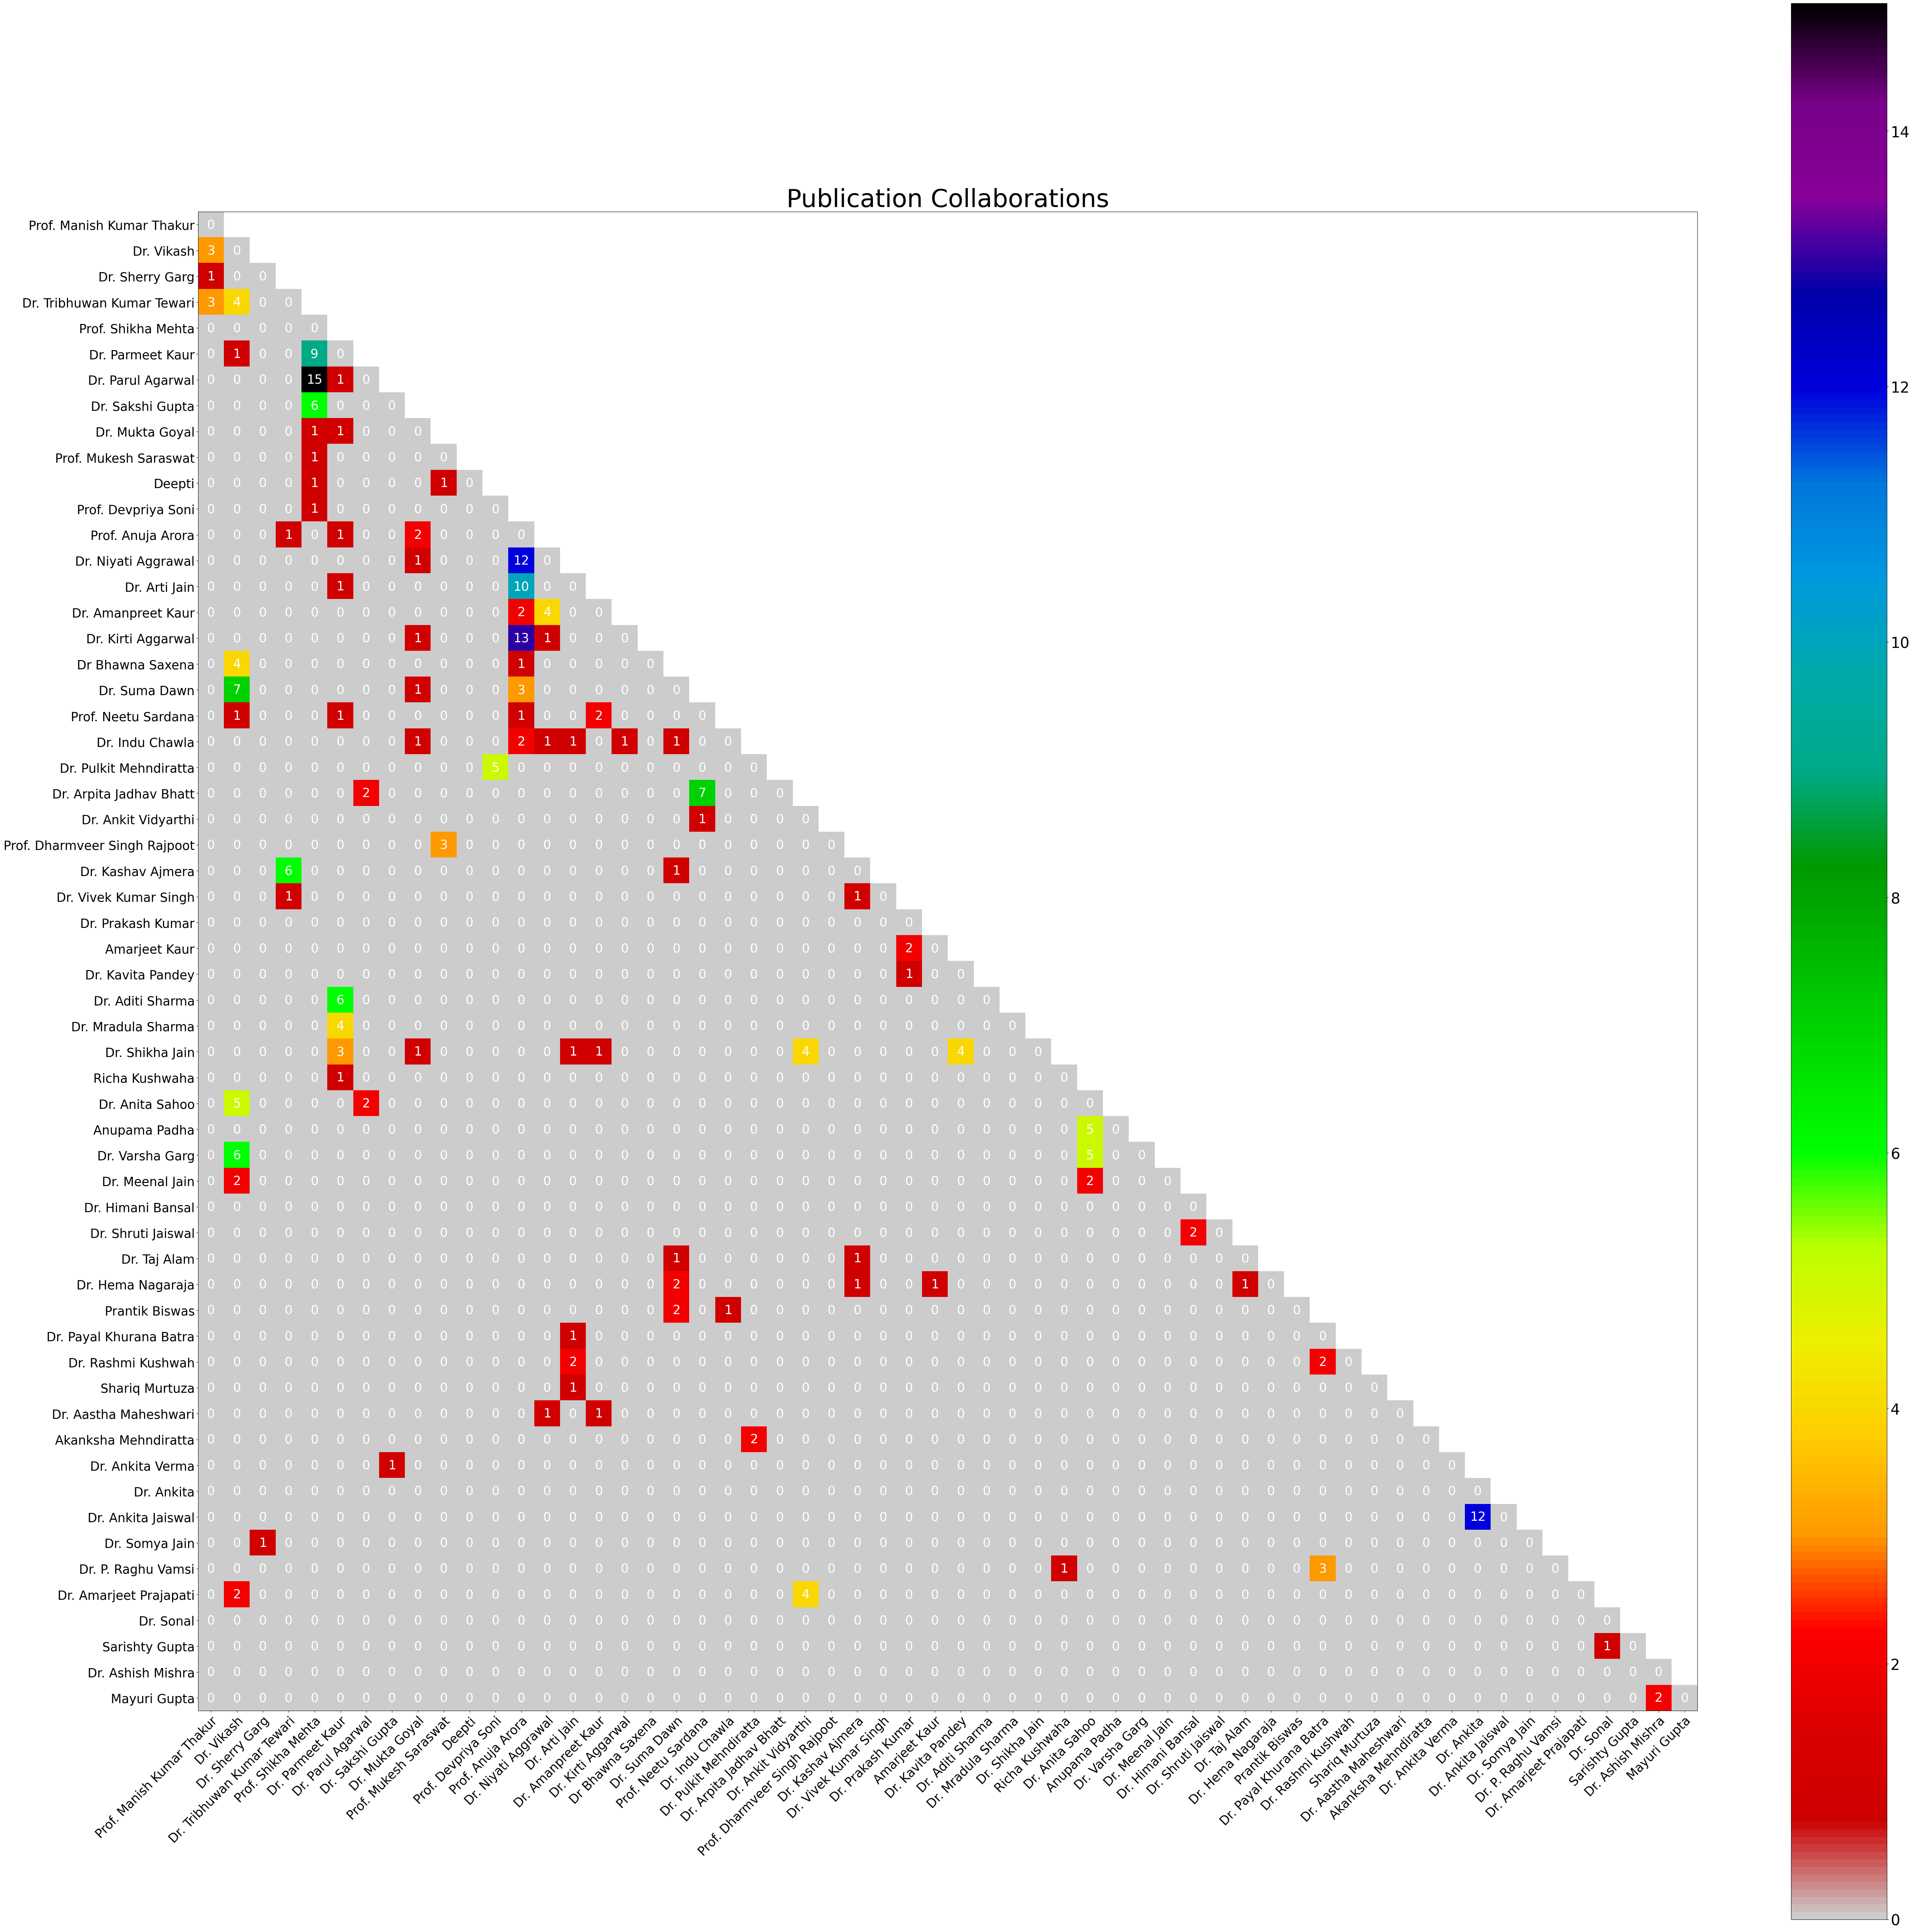

In [11]:
authors = list(collabs_dict.keys())
author_count=len(authors)
# Initialize array with zeros. 
collabs_array = np.zeros((author_count, author_count), dtype=int)

# Populate the array with the number of collaborations between authors
for i, athr in enumerate(authors):
    for j, name in enumerate(authors):
        if name in collabs_dict[athr].keys():
            collabs_array[i][j] = collabs_dict[athr][name]
            
# Only display the lower triangle of the matrix
mask =  np.tri(collabs_array.shape[0], k=-1)
collabs_array = np.ma.array(collabs_array, mask=mask).T

# Set up the colourmap 
cmap = plt.colormaps['nipy_spectral']
cmap = cmap.reversed()

### Create heatmap ###

fig = plt.figure(figsize = (author_count,author_count)) 
ax = fig.add_subplot(111)
im = ax.imshow(collabs_array, cmap=cmap, interpolation='nearest', 
               #norm=matplotlib.colors.LogNorm()            # Uncomment this if you want a logarithmic colormap
              )

# Show the ticks
ax.set_xticks(np.arange(author_count))
ax.set_yticks(np.arange(author_count))

# Label the ticks with author names - you can modify the authorname font size here
ax.set_xticklabels(authors,fontsize=25)
ax.set_yticklabels(authors, fontsize=25)

# Rotate and align tick labels.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create numeric annotations.
for i in range(author_count):
    for j in range(author_count):
        text = ax.text(j, i, collabs_array[i, j],
                       ha="center", va="center", color="w", fontsize=25)
# Fit plot within figure        
fig.tight_layout()


# Add title - you can change the title and title font size here
ax.set_title("Publication Collaborations", fontsize = 50)

# Add the colorbar and add ticks - change colorbar label fontsize here
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=30)

# Save the figure as PDF - you can modify the filename here. 
plt.savefig("Example Outputs/Graphs/heatmap.pdf")

plt.show()
